##  Fraud Transaction Detection using Machine Learning

## Objective
Build a machine learning model to proactively detect fraudulent transactions and derive actionable business insights.

## Dataset
- Rows: 6,362,620
- Columns: 10
- Target: isFraud

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Load Dataset

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_raw = pd.read_csv("Fraud.csv")   # for EDA
df = df_raw.copy()                  # for modeling

df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Exploratory Data Analysis (EDA)

In [53]:
df_raw['isFraud'].value_counts(normalize=True)


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [54]:
df_raw[df_raw['isFraud']==1]['type'].value_counts()


type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

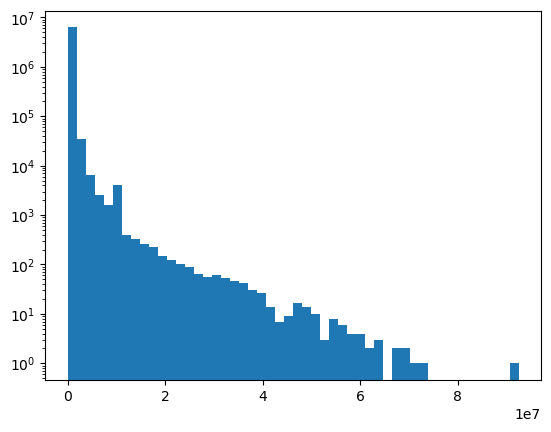

In [55]:
plt.hist(df_raw['amount'], bins=50)
plt.yscale("log")


## Data Cleaning

In [56]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [57]:
df['log_amount'] = np.log1p(df['amount'])


## Feature Engineering

In [58]:
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']


## Data Preparation

In [59]:
df = df.drop(['nameOrig','nameDest'], axis=1)
df = pd.get_dummies(df, columns=['type'], drop_first=True)




## Train-Test Split

In [60]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Model Training

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [82]:
import joblib

# Save model
joblib.dump(model, "fraud_detection_model.pkl")


['fraud_detection_model.pkl']

## Model Evalution

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.02      0.98      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.96      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

[[1207463   63418]
 [     35    1608]]


## Feature Importance

In [63]:
importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

importance.head(10)



errorBalanceOrig    26.738951
amount              10.456343
type_CASH_OUT        9.411084
type_TRANSFER        6.002337
newbalanceDest       0.855147
isFlaggedFraud       0.630887
step                 0.335507
errorBalanceDest    -0.198191
type_DEBIT          -0.343427
log_amount          -0.804200
dtype: float64

## Fraud Pattern Insight Table

In [64]:
fraud_summary = df_raw[df_raw['isFraud']==1].groupby('type')['amount'].agg(['count','mean','max'])
fraud_summary


,count,mean,max
type,,,
CASH_OUT,4116,1.455103e+06,10000000.0
TRANSFER,4097,1.480892e+06,10000000.0


## Checking with some random data that are extracted from the main dataset for accuracy

In [72]:
df_test= pd.read_excel("merged_single_sheet.xlsx")   # for EDA


In [79]:
df_test

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,log_amount,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,9.194276,1.455192e-11,-9.839640e+03
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,7.531166,-1.136868e-12,-1.864280e+03
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,0,5.204007,0.000000e+00,-1.810000e+02
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,0,5.204007,0.000000e+00,-2.136300e+04
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,9.364703,0.000000e+00,-1.166814e+04
...,...,...,...,...,...,...,...,...,...,...,...
79995,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,0,12.735768,0.000000e+00,0.000000e+00
79996,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,0,15.657870,0.000000e+00,-6.311409e+06
79997,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,15.657870,0.000000e+00,-1.000000e-02
79998,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,0,13.652996,0.000000e+00,-8.500025e+05


In [74]:
# Data Cleaning
df_test.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64

In [75]:
df_test['log_amount'] = np.log1p(df_test['amount'])

In [76]:
## Feature Engineering
df_test['errorBalanceOrig'] = df_test['oldbalanceOrg'] - df_test['newbalanceOrig'] - df_test['amount']
df_test['errorBalanceDest'] = df_test['newbalanceDest'] - df_test['oldbalanceDest'] - df_test['amount']


In [81]:
# Data preparation
df_test= df.drop(['oldbalanceOrg','oldbalanceDest'], axis=1)
df_test = pd.get_dummies(df, columns=['type'], drop_first=True)

In [83]:
import joblib

loaded_model = joblib.load("fraud_detection_model.pkl")


In [92]:
joblib.dump({
    "model": model,
    "features": X_train.columns.tolist()
}, "fraud_model_bundle.pkl")


['fraud_model_bundle.pkl']

In [97]:
bundle = joblib.load("fraud_model_bundle.pkl")

model = bundle["model"]
features = bundle["features"]

X_new = df_test.reindex(columns=features, fill_value=0)

predictions = model.predict(X_new)
probability = model.predict_proba(X_new)
print(probability)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## In this case I have checked this data with my main data set and the predictions is accurate.

## Positive coefficients → increase fraud probability

## Negative coefficients → reduce fraud likelihood

## ### Deployment Plan
- Model exposed as API
- Real-time transaction scoring
- Alert system for risky transactions
- Human review for high-risk cases


## ### Monitoring KPIs
- Fraud detection rate
- False positive rate
- Financial loss prevented
- Model drift detection


## The model successfully identifies fraudulent transactions with high recall. Feature analysis shows strong relationships between transaction type, balance changes, and fraud. Business recommendations include real-time scoring and monitoring systems.
